# Credit Card Fraud Detection

[Anonymized credit card transactions labeled as fraudulent or genuine](https://www.kaggle.com/mlg-ulb/creditcardfraud).

## Config

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from scipy.stats import pointbiserialr
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

from plotting_utils import (plot_confusion_matrix, precision_recall,
                            plot_1d_corr_heatmap, plot_overlapping_histograms,
                            countplot_independent_ylims)

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# exibe todas as colunas do DataFrame
pd.options.display.max_columns = 35

# deixa de utilizar a notação científica
pd.options.display.float_format = lambda x: '%.2f' % x

## Preparação do dataset

In [4]:
df = pd.read_csv('../data/creditcard.csv')

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

É importante já separarmos o dataset de teste, assim garantimos que não iremos tocar nele. Até para a análise dos dados isso pode ser importante, já que nos impede de tomar decisões de feature engineering baseadas nesses dados.

In [6]:
X = df.drop(columns='Class')
y = df['Class']

Aqui vale frisar também que a função `train_test_split` já tem os parâmetros `shuffle` e `stratify` com valores `True` por padrão, caso contrário teríamos que setá-los explicitamente.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=0)

In [8]:
print('Tamanho dos datasets:', (len(y_train), len(y_test)))

Tamanho dos datasets: (199364, 85443)


Vamos juntar as features com o target para analisá-los em um dataframe de treino unificado.

In [9]:
train_idx = y_train.index.sort_values()
df_train = df.loc[train_idx]

## Análise Exploratória Express

In [10]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0
6,4.00,1.23,0.14,0.05,1.20,0.19,0.27,-0.01,0.08,0.46,-0.10,-1.42,-0.15,-0.75,0.17,0.05,-0.44,0.00,-0.61,-0.05,-0.22,-0.17,-0.27,-0.15,-0.78,0.75,-0.26,0.03,0.01,4.99,0
7,7.00,-0.64,1.42,1.07,-0.49,0.95,0.43,1.12,-3.81,0.62,1.25,-0.62,0.29,1.76,-1.32,0.69,-0.08,-1.22,-0.36,0.32,-0.16,1.94,-1.02,0.06,-0.65,-0.42,-0.05,-1.21,-1.09,40.80,0


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199364 entries, 1 to 284806
Data columns (total 31 columns):
Time      199364 non-null float64
V1        199364 non-null float64
V2        199364 non-null float64
V3        199364 non-null float64
V4        199364 non-null float64
V5        199364 non-null float64
V6        199364 non-null float64
V7        199364 non-null float64
V8        199364 non-null float64
V9        199364 non-null float64
V10       199364 non-null float64
V11       199364 non-null float64
V12       199364 non-null float64
V13       199364 non-null float64
V14       199364 non-null float64
V15       199364 non-null float64
V16       199364 non-null float64
V17       199364 non-null float64
V18       199364 non-null float64
V19       199364 non-null float64
V20       199364 non-null float64
V21       199364 non-null float64
V22       199364 non-null float64
V23       199364 non-null float64
V24       199364 non-null float64
V25       199364 non-null float64
V26  

Já que a maioria das features foram geradas com PCA, a correlação entre elas será baixa.
Vamos então analisar a correlação das features com o target `Class`.

Enquanto as features são contínuas, o target é binário. Para correlação entre uma variável contínua e uma binária, utilizaremos o coeficiente de correlação [Ponto Biserial](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html).

In [12]:
def point_biserial_corr(binary_series, continuous_df):
    corr = {}
    for col_name in continuous_df:
        corr[col_name] = pointbiserialr(binary_series, 
                                        continuous_df[col_name]).correlation
    
    return pd.Series(corr, name=f"Correlation with '{binary_series.name}'")

In [13]:
corr = point_biserial_corr(y_train, X_train)

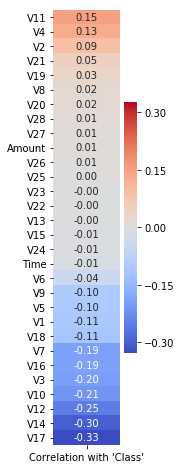

In [14]:
plot_1d_corr_heatmap(corr)


### Class

In [15]:
df_train['Class'].value_counts()

0    199019
1       345
Name: Class, dtype: int64

### Time

Vamos verificar se a coluna `Time` não deveria ser `int`:

In [16]:
df_train['Time'].apply(float.is_integer).all()

True

In [17]:
def time_to_int(dataframe):
    df_copy = dataframe.copy()
    df_copy['Time'] = df_copy['Time'].astype(int)
    return df_copy

In [18]:
df_train = time_to_int(df_train)

In [19]:
n_time_bins = 24
time_bins = range(0, 
                  df_train['Time'].max(), 
                  df_train['Time'].max() // n_time_bins)
list(time_bins)

[0,
 7199,
 14398,
 21597,
 28796,
 35995,
 43194,
 50393,
 57592,
 64791,
 71990,
 79189,
 86388,
 93587,
 100786,
 107985,
 115184,
 122383,
 129582,
 136781,
 143980,
 151179,
 158378,
 165577,
 172776]

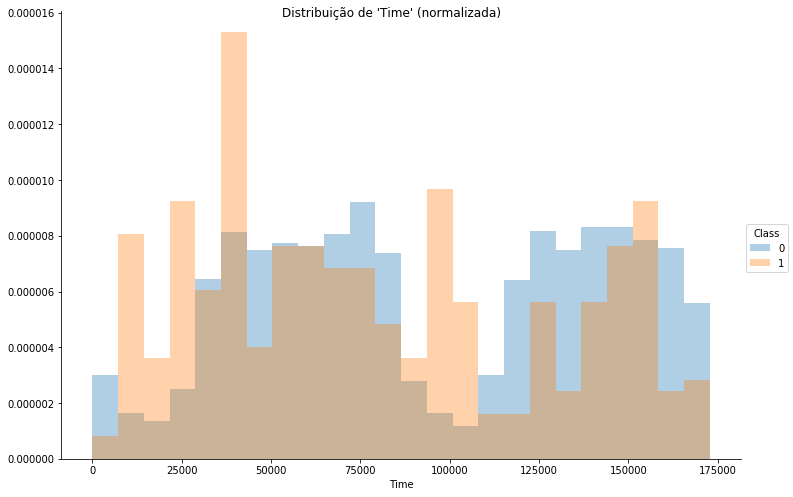

In [21]:
plot_overlapping_histograms(df_train, col='Time', hue='Class', bins=time_bins,
                            title="Distribuição de 'Time' (normalizada)")

In [22]:
day_1_daytime_start = time_bins[4]
day_1_daytime_end = time_bins[12]

day_2_daytime_start = time_bins[16]
day_2_daytime_end = time_bins[24]

In [23]:
def add_daytime_col(dataframe):
    df_copy = dataframe.copy()
    
    df_copy['Time_daytime'] = (((df_copy['Time'] >= day_1_daytime_start) 
                                  & (df_copy['Time'] <= day_1_daytime_end))
                                | ((df_copy['Time'] >= day_2_daytime_start) 
                                  & (df_copy['Time'] <= day_2_daytime_end))).astype(int)
    
    return df_copy

In [24]:
df_train = add_daytime_col(df_train)

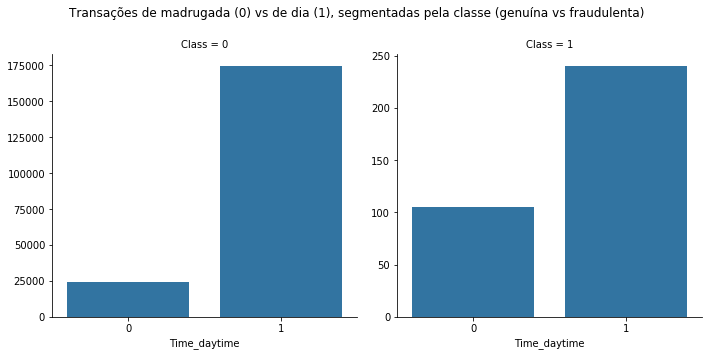

In [25]:
countplot_independent_ylims(df_train, col='Time_daytime', hue='Class', 
                            hue_order=[0, 1],
                            title='Transações de madrugada (0) vs de dia (1), '
                                  'segmentadas pela classe (genuína vs fraudulenta)')

É possível ver acima que a proporção de transações fraudulentas no que julgamos ser o período da madrugada parece ser maior do que o normal.

### Amount

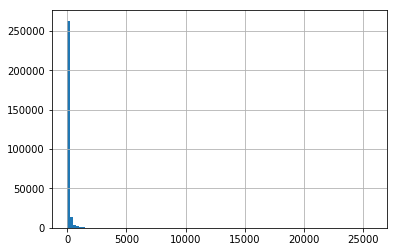

In [26]:
df['Amount'].hist(bins=100)

In [27]:
high_transactions = df['Amount'] > 1500

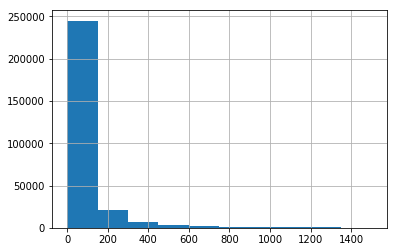

In [28]:
df.loc[~high_transactions, 'Amount'].hist()

É possível que uma transformação de log funcione bem para `Amount`. 

Antes disso, vamos verificar se existem valores comuns em caso de fraude.

In [29]:
fraud = df_train['Class'] == 1

In [30]:
(df_train.loc[fraud, 'Amount']
     .value_counts()
     .sort_values(ascending=False)
     .head(15))

1.00      66
99.99     21
0.00      20
0.76      12
0.77       7
3.79       4
1.10       3
0.01       3
1.59       2
1.52       2
30.31      2
101.50     2
104.03     2
723.21     2
252.92     2
Name: Amount, dtype: int64

Vamos comparar as proporções desses 3 valores mais comuns com as transações genuinas.

In [31]:
def add_amount_cols(dataframe):
    df_copy = dataframe.copy()
    df_copy['Amount_1'] = df_copy['Amount'] == 1
    df_copy['Amount_99_99'] = df_copy['Amount'] == 99.99
    df_copy['Amount_0'] = df_copy['Amount'] == 0
    return df_copy

In [32]:
df_train = add_amount_cols(df_train)

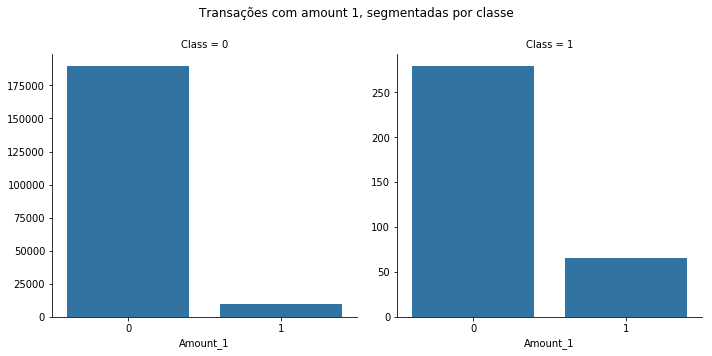

In [33]:
countplot_independent_ylims(df_train, col='Amount_1', hue='Class', 
                            hue_order=[0, 1],
                            title='Transações com amount 1, '
                                  'segmentadas por classe')

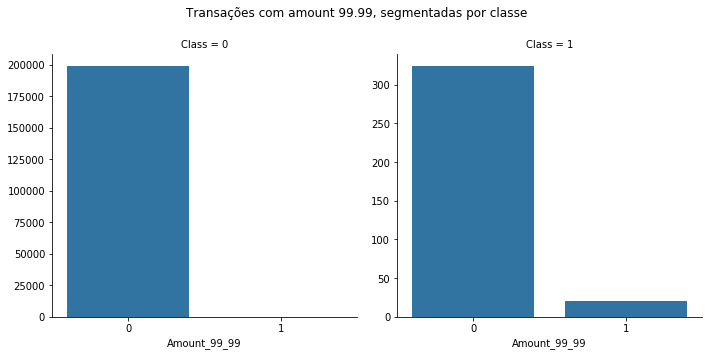

In [34]:
countplot_independent_ylims(df_train, col='Amount_99_99', hue='Class', 
                            hue_order=[0, 1],
                            title='Transações com amount 99.99, '
                                  'segmentadas por classe')

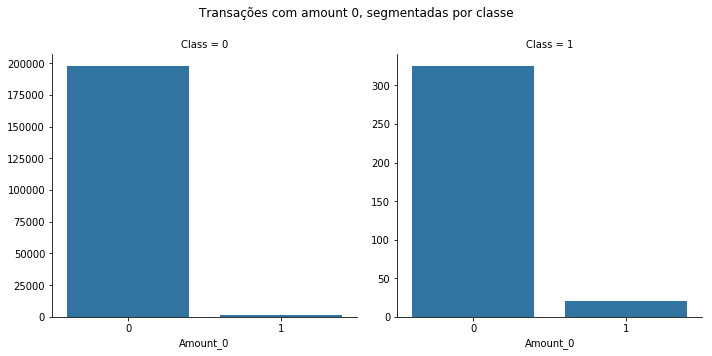

In [35]:
countplot_independent_ylims(df_train, col='Amount_0', hue='Class', 
                            hue_order=[0, 1],
                            title='Transações com amount 0, '
                                  'segmentadas por classe')

Vamos manter essas 3 features - elas podem ser úteis.

No mais, apesar de estranho, temos transações de valor zero tanto em transações genuínas quanto em fraudes. Dessa forma, aplicaremos o log somente para efeito de visualização.

De qualquer forma, vamos observar os valores `log(99.99)` e `log(1)=0`.

In [36]:
np.log(99.99)

4.6050701809877577

In [37]:
amount_0 = df_train['Amount_0']
df_train['Amount_log'] = np.log(df_train.loc[~amount_0, 'Amount'])

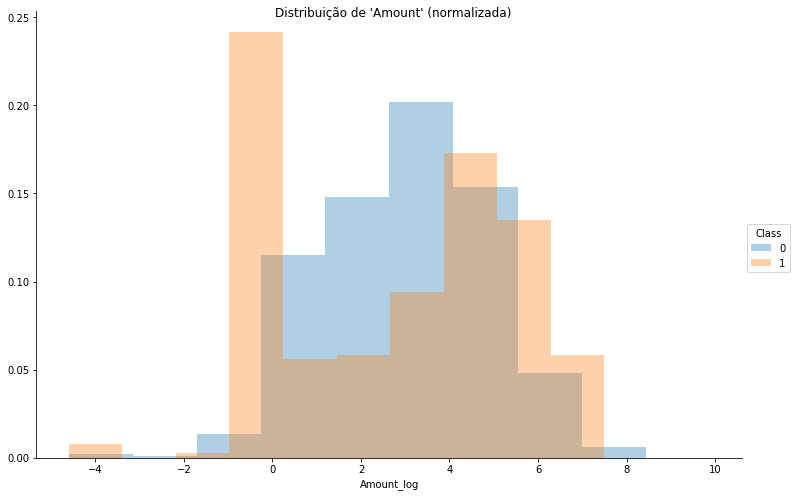

In [38]:
plot_overlapping_histograms(df_train, col='Amount_log', hue='Class',
                            title="Distribuição de 'Amount' (normalizada)")

### Features anonimizadas

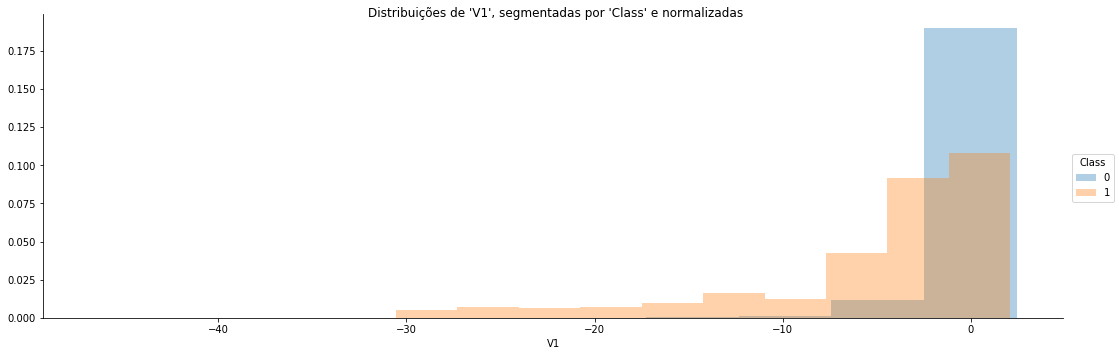

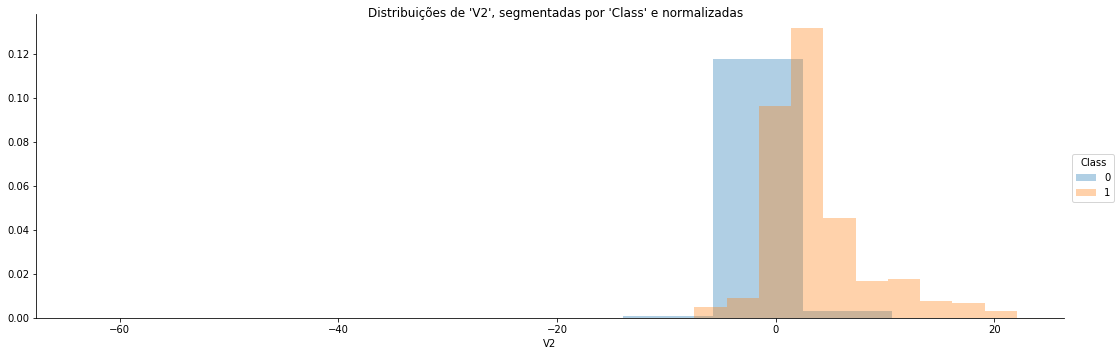

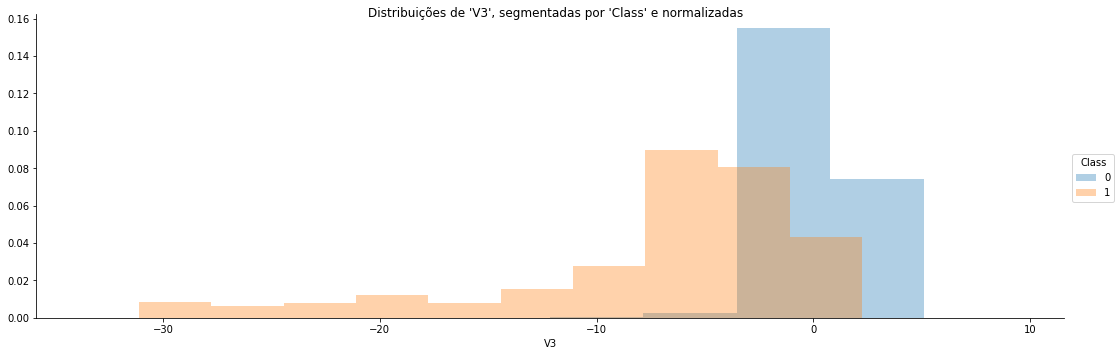

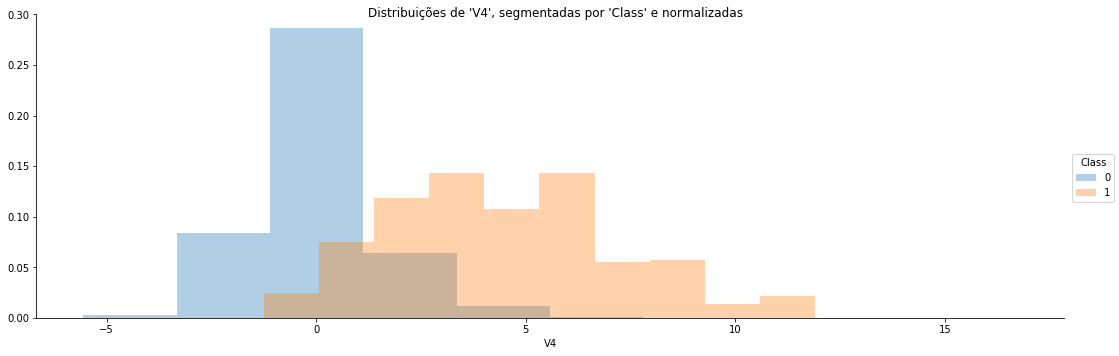

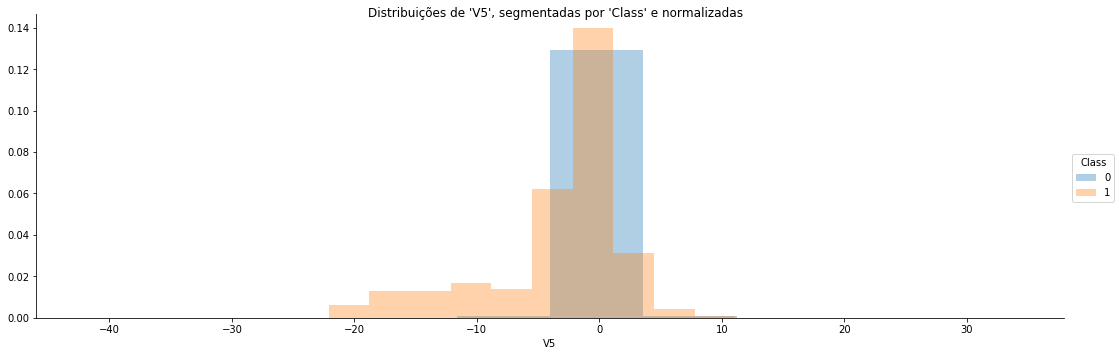

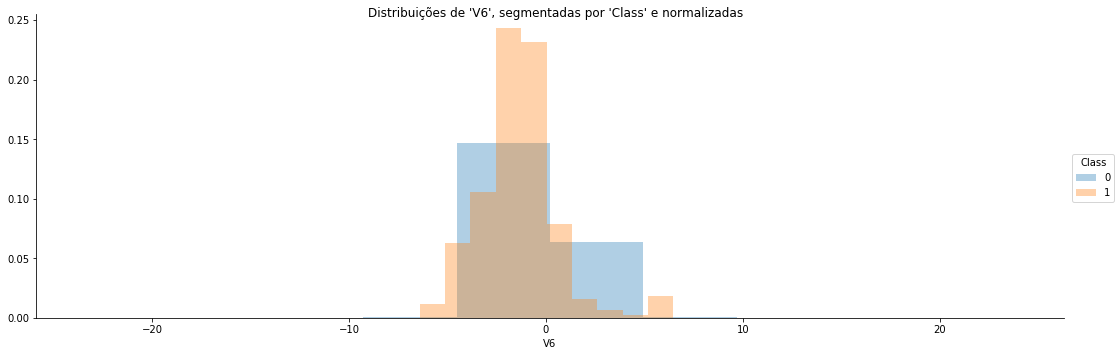

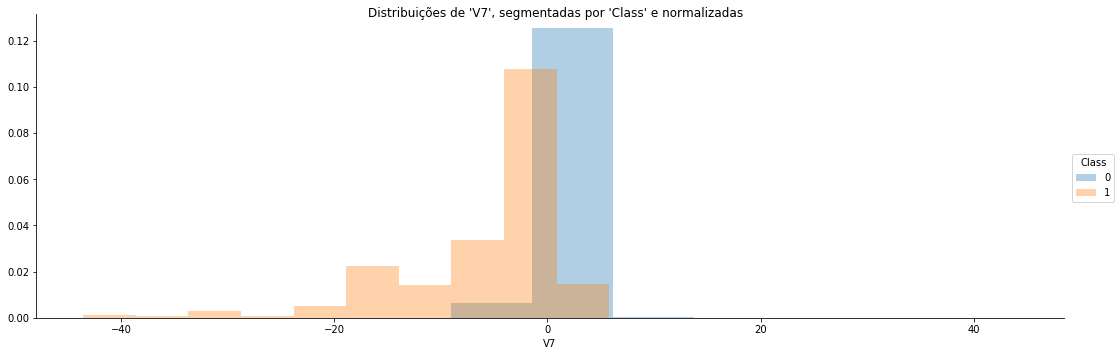

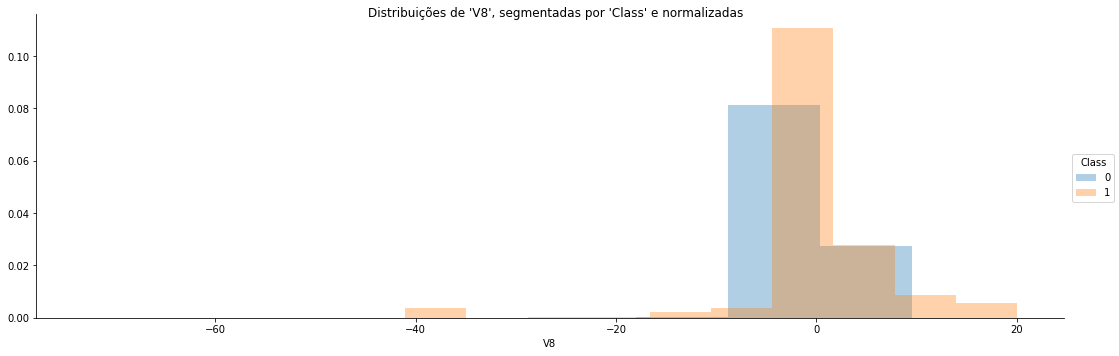

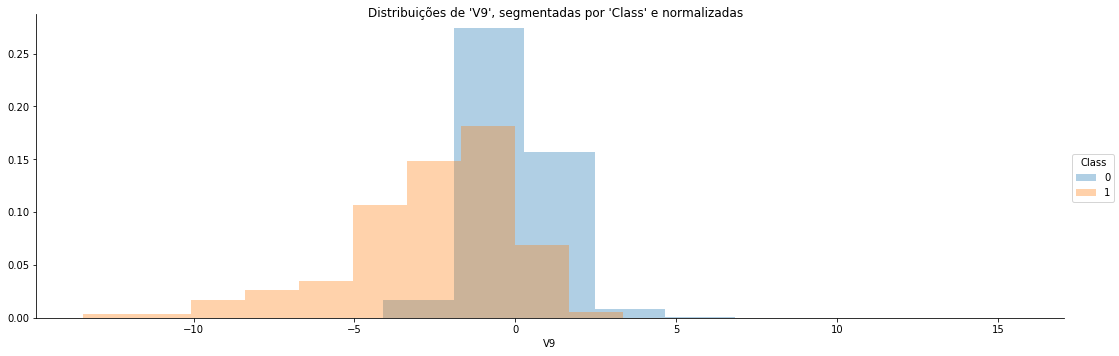

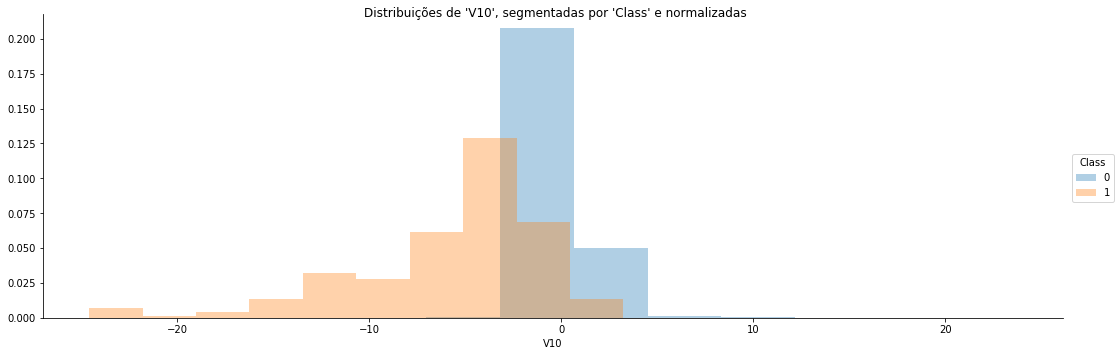

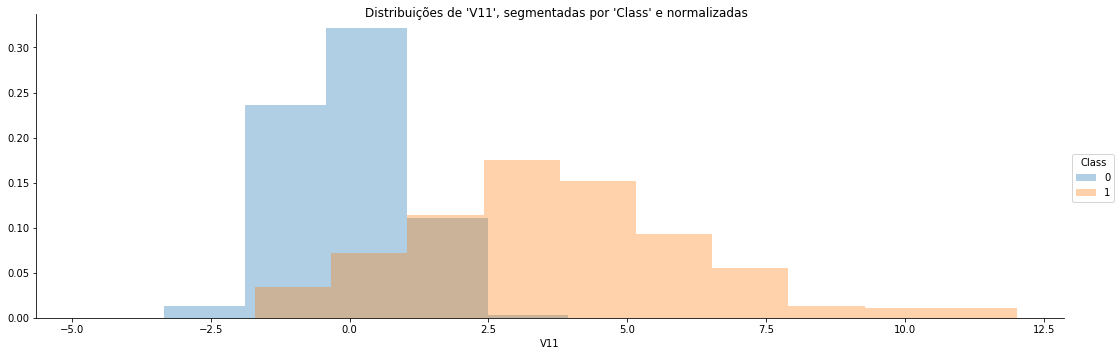

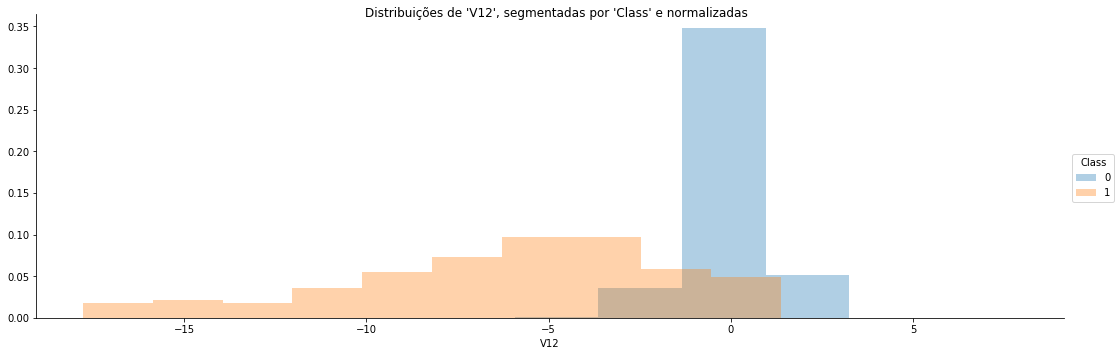

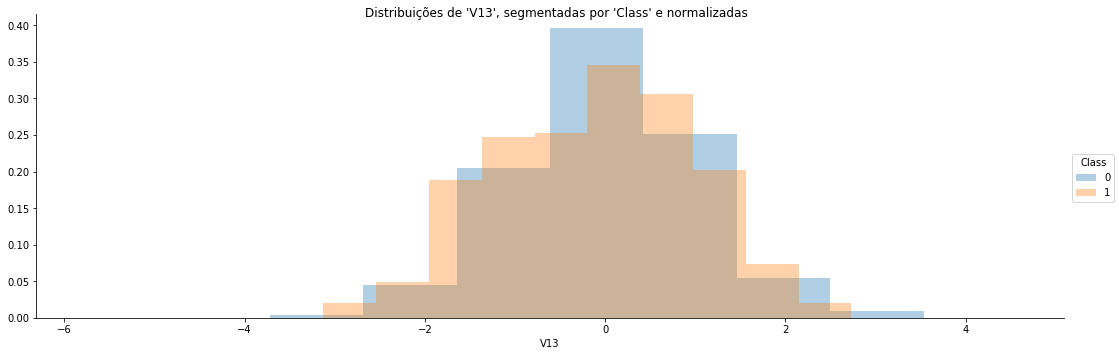

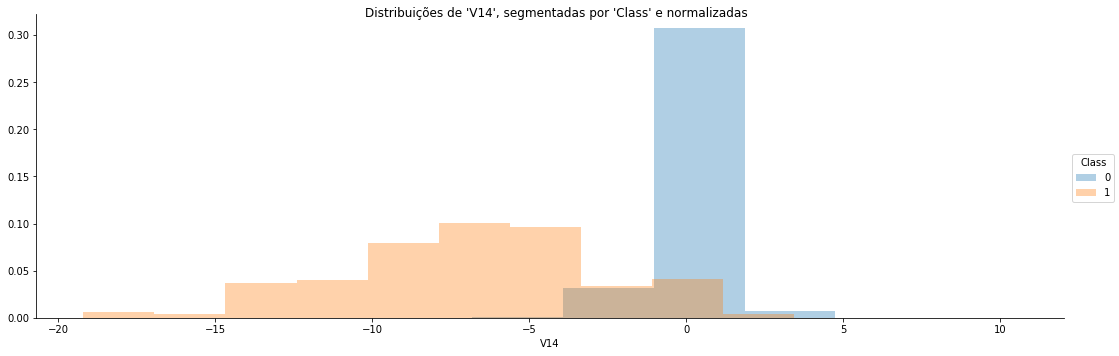

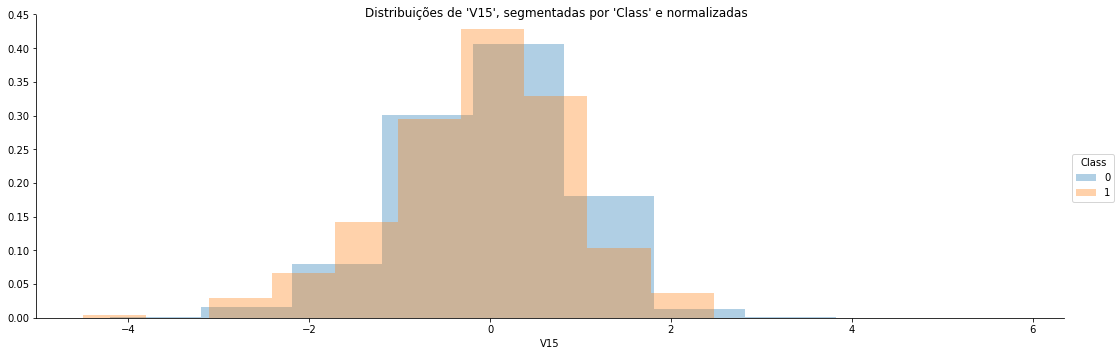

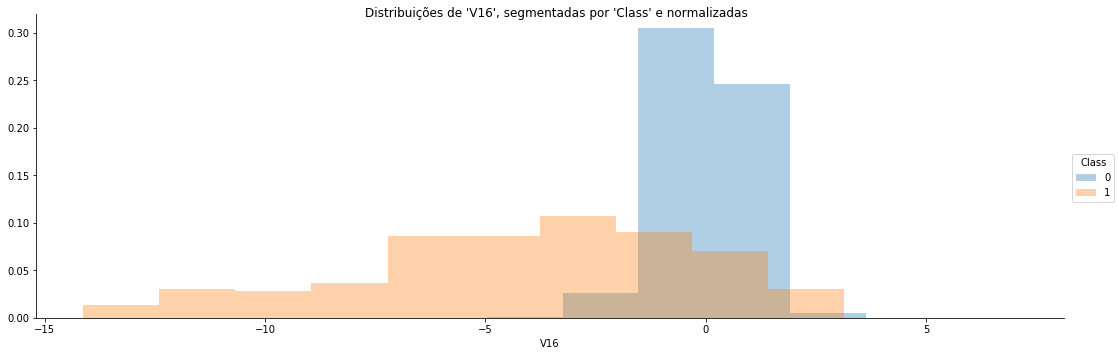

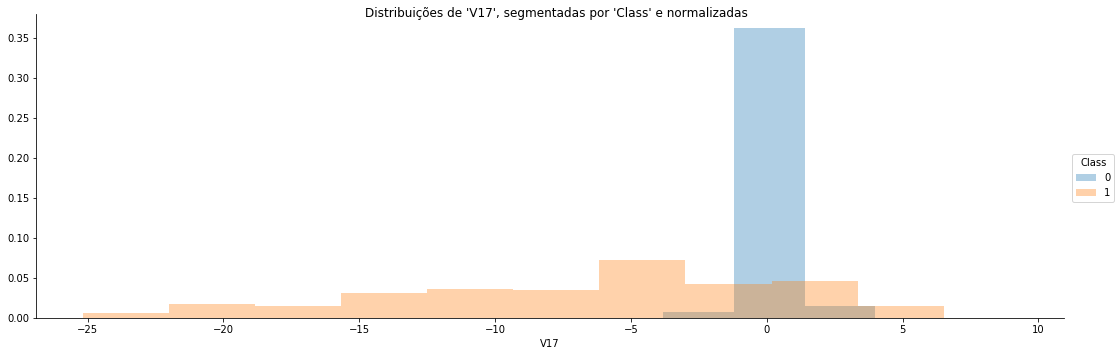

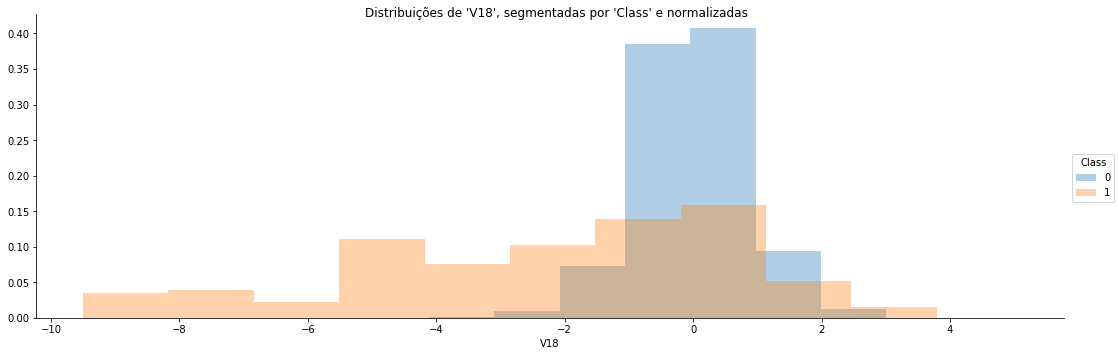

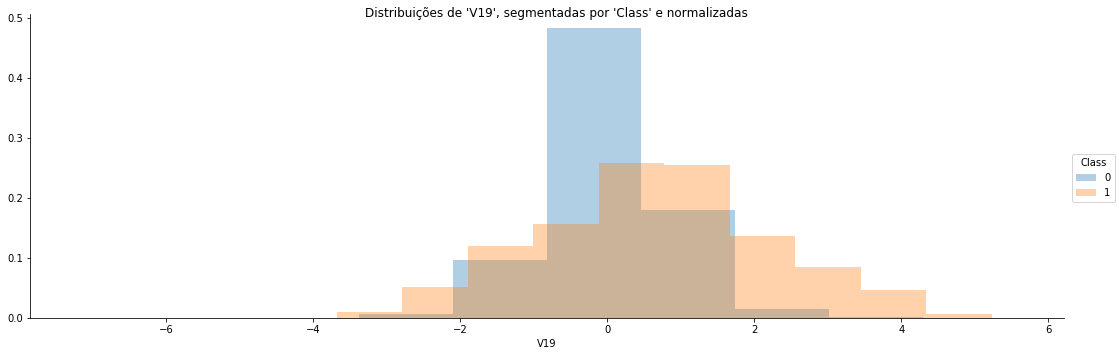

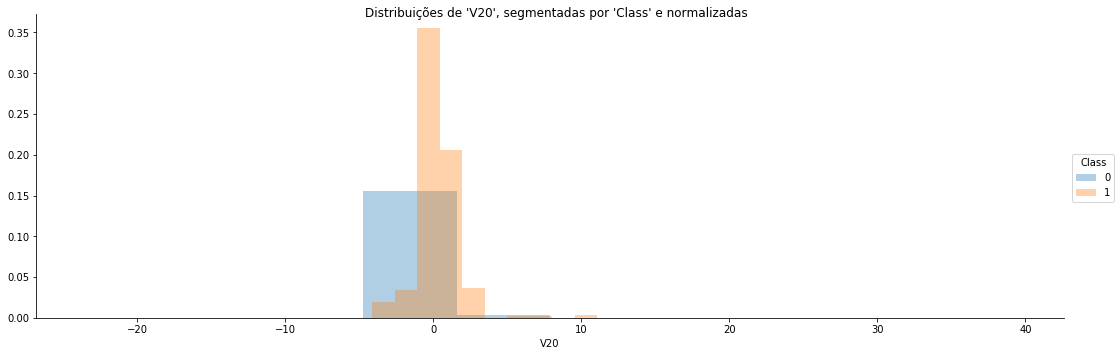

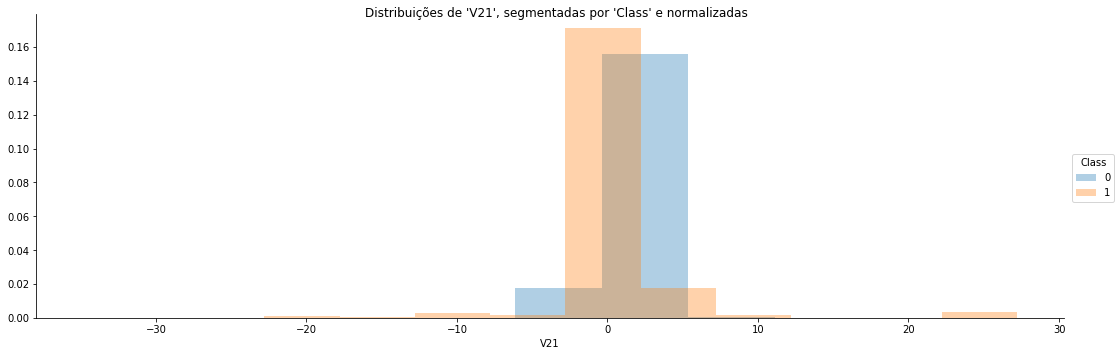

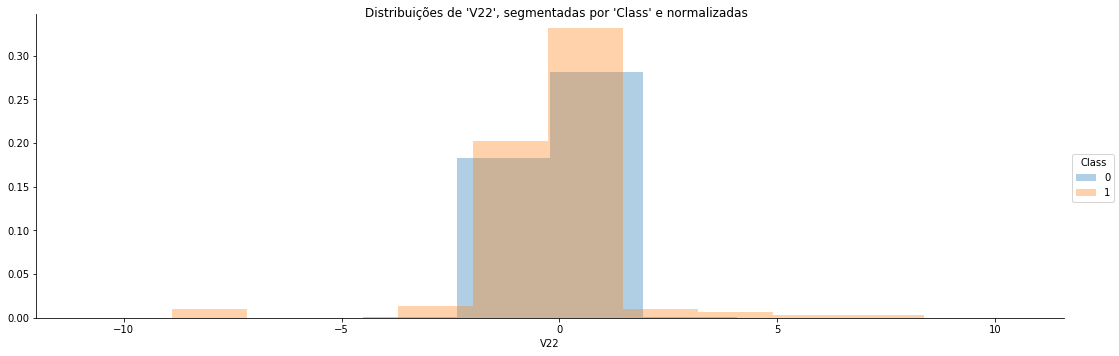

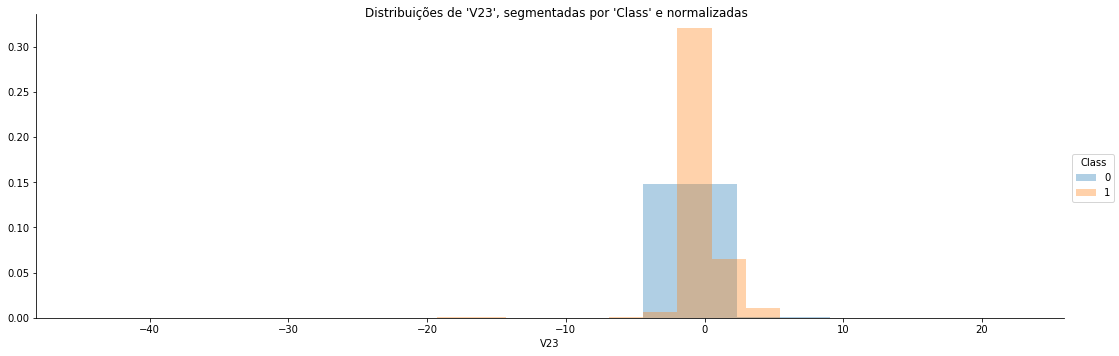

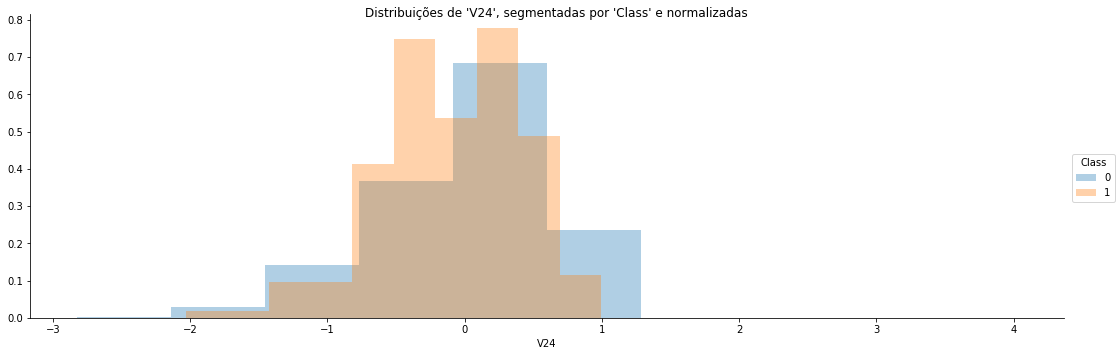

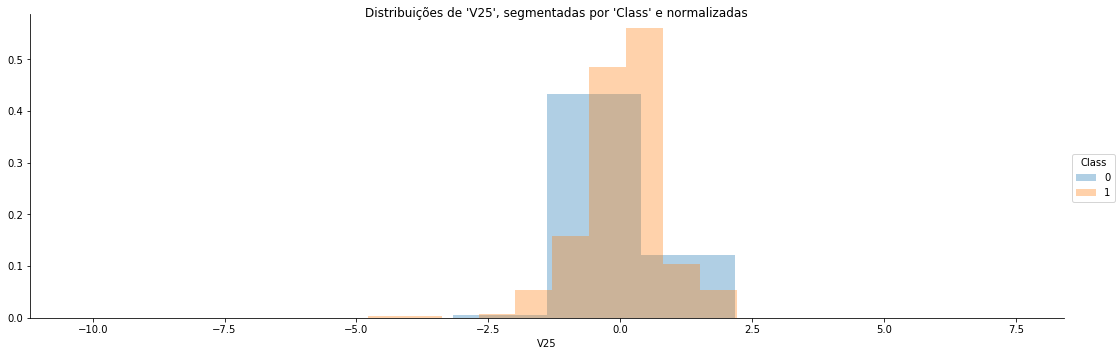

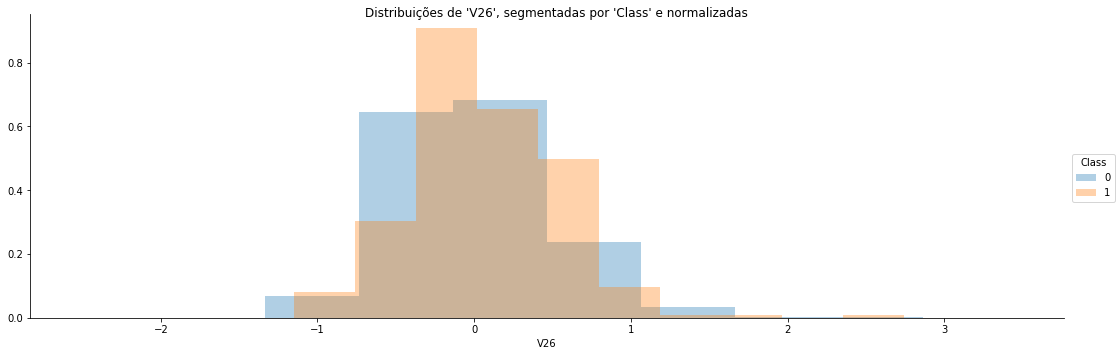

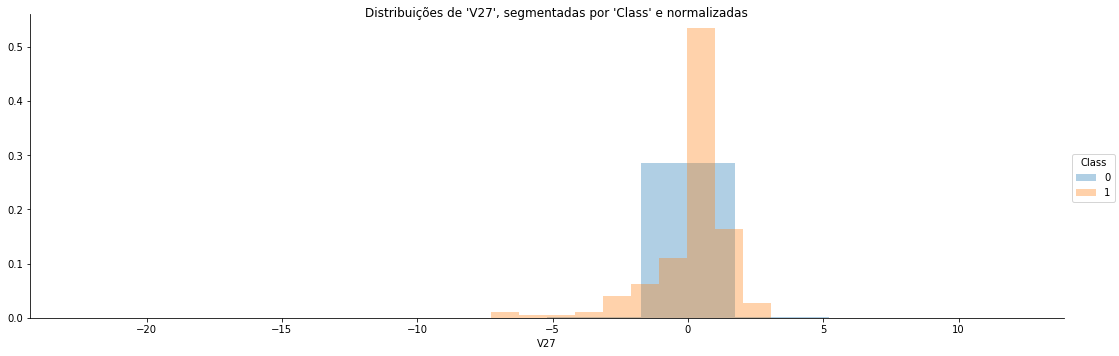

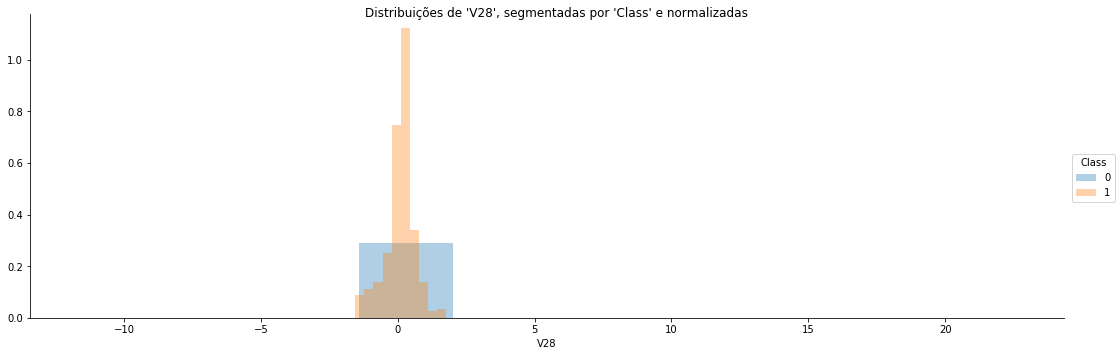

In [86]:
n_vars = 28
for var in range(1, n_vars+1):
    plot_overlapping_histograms(df_train, col=f'V{var}', hue='Class',
                                size=5, aspect=3,
                                title=f"Distribuições de 'V{var}', "
                                       "segmentadas por 'Class' e normalizadas")

Podemos ver acima que algumas variáveis parecem ter mais poder preditivo do que outras.

Vamos seguir para a modelagem.

## Pipeline de pré-processamento

Antes de treinar o modelo e fazer predições, vamos aplicar as transformações nos dados que julgamos úteis na seção anterior.

Obs.: como nós fizemos os testes em `df_train`, `X_train` não foi modificado e também precisará passar pelo pré-processador.

In [40]:
pre_processor = make_pipeline(FunctionTransformer(time_to_int, validate=False),
                              FunctionTransformer(add_daytime_col, validate=False),
                              FunctionTransformer(add_amount_cols, validate=False))

In [41]:
X_train = pre_processor.fit_transform(X_train)
X_test = pre_processor.fit_transform(X_test)

Obs.: como só utilizamos algoritmos baseados em árvores, o pré-processador não deve trazer grandes melhorias. Essas transformações provavelmente seriam mais efetivas se fossem utilizados algoritmos lineares. Pelo mesmo motivo, não há necessidade de analisarmos colinearidade entre features, nem de remover outliers e nem de normalizar os dados.

## Modelagem

### 1) Bagging de Decision Trees sem levar em conta as classes desbalanceadas

In [42]:
base_estimator = DecisionTreeClassifier(max_depth=2)

bagging = BaggingClassifier(base_estimator=base_estimator,
                            n_estimators=100,
                            random_state=0, n_jobs=-1)

In [43]:
_ = bagging.fit(X_train, y_train)

Agora vamos calcular os scores estimados pelo preditor. Ou seja, vamos invocar o método `predict_proba`, não o método `predict`.

In [44]:
bagging_y_score = bagging.predict_proba(X_test)[:, 1]

Com os scores em mãos, podemos agora utilizar a curva Precision-Recall para nos ajudar a escolher o ponto de corte em que nós temos um bom trade-off entre precisão e recall. Para isso, otimizaremos o [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

A função [`precision_recall`](plotting_utils.py) plota a curva e retorna um DataFrame com os valores de precisão, recall e F1-score para cada threshold (ponto de corte).

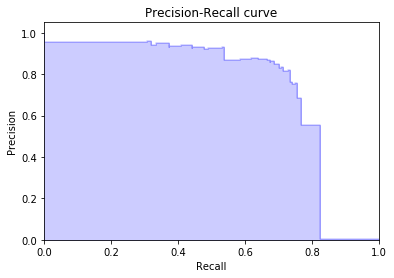

In [45]:
bagging_results = precision_recall(y_test, bagging_y_score)

In [46]:
bagging_results.head()

,precision,recall,threshold,f1_score
0,0.00,1.00,0.00,0.00
1,0.55,0.82,0.00,0.66
2,0.56,0.82,0.00,0.66
3,0.65,0.77,0.00,0.70
4,0.65,0.77,0.01,0.71


Vamos agora ordenar o DataFrame pelo F1-score.

In [47]:
bagging_report = bagging_results.sort_values(by='f1_score', ascending=False)
bagging_best_threshold = bagging_report.loc[bagging_report['f1_score'].idxmax(), 
                                            'threshold']

In [48]:
pd.options.display.float_format = lambda x: '%.3f' % x

In [49]:
bagging_report.head(15)

,precision,recall,threshold,f1_score
27,0.818,0.735,0.430,0.774
26,0.812,0.735,0.380,0.771
28,0.817,0.728,0.454,0.770
33,0.833,0.714,0.517,0.769
25,0.806,0.735,0.249,0.769
38,0.851,0.701,0.567,0.769
32,0.827,0.714,0.516,0.766
37,0.844,0.701,0.554,0.766
29,0.815,0.721,0.473,0.765
42,0.863,0.687,0.617,0.765


Agora que descobrimos o ponto de corte que maximiza o F1-score, vamos calcular as predições (transação genuina ou fraude) para que possamos destrinchar os resultados em uma matriz de confusão. 

In [50]:
bagging_y_pred = bagging_y_score >= bagging_best_threshold

In [51]:
print(classification_report(y_test, bagging_y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.82      0.73      0.77       147

avg / total       1.00      1.00      1.00     85443



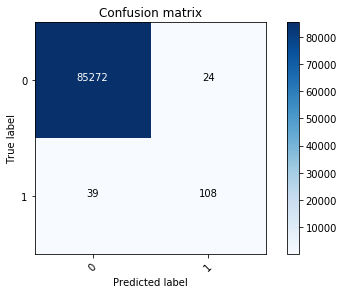

In [52]:
plot_confusion_matrix(y_test, bagging_y_pred, 
                      class_names=[0, 1])

### 2) Random Forest com classes previamente balanceadas via undersampling

Vamos realizar o mesmo procedimento do modelo anterior, porém vamos antes fazer um undersampling dos dados.
A desvantagem dessa estratégia é que nós arriscamos perder informação presente nos samples ignorados.

Para o undersampling, iremos utilizar a classe [`RandomUnderSampler`](http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.under_sampling.RandomUnderSampler.html) do pacote [`imbalanced_learn`](http://contrib.scikit-learn.org/imbalanced-learn/stable/user_guide.html).

In [53]:
resampler = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = resampler.fit_sample(X_train, y_train)

In [54]:
(y_train.shape[0], y_resampled.shape[0])

(199364, 690)

In [55]:
clf = RandomForestClassifier(n_estimators=100, max_features=3)

In [56]:
_ = clf.fit(X_resampled, y_resampled)

In [57]:
clf_y_score = clf.predict_proba(X_test)[:, 1]

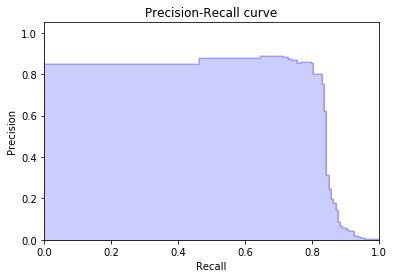

In [58]:
clf_results = precision_recall(y_test, clf_y_score)

In [59]:
clf_report = clf_results.sort_values(by='f1_score', ascending=False)
clf_best_threshold = clf_report.loc[clf_report['f1_score'].idxmax(), 
                                    'threshold']

In [60]:
clf_report.head(10)

,precision,recall,threshold,f1_score
89,0.855,0.803,0.890,0.828
91,0.860,0.796,0.910,0.827
90,0.854,0.796,0.900,0.824
88,0.831,0.803,0.880,0.817
86,0.803,0.830,0.860,0.816
92,0.856,0.769,0.920,0.810
87,0.800,0.816,0.870,0.808
93,0.867,0.755,0.930,0.807
94,0.872,0.741,0.950,0.801
85,0.772,0.830,0.850,0.800


In [61]:
clf_y_pred = clf_y_score >= clf_best_threshold

In [62]:
print(classification_report(y_test, clf_y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.86      0.80      0.83       147

avg / total       1.00      1.00      1.00     85443



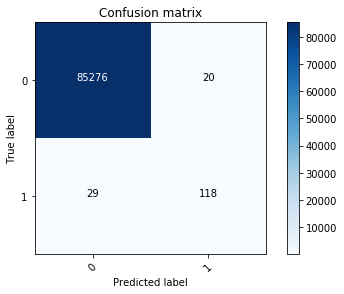

In [63]:
plot_confusion_matrix(y_test, clf_y_pred, 
                      class_names=[0, 1])

### 3) Ensemble de Random Forests, cada uma com uma amostra diferente da classe dominante

Dessa vez, ao invés de descartar samples da classe dominante, nós iremos criar um ensemble em que cada um dos modelos utiliza uma amostra aleatória dos dados da classe dominante. Já a classe minoritária é utilizada por completo em todos os modelos.

Para isso, utilizaremos a classe [`BalancedBaggingClassifier`](http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html) do pacote [`imbalanced-learn`](http://contrib.scikit-learn.org/imbalanced-learn/stable/user_guide.html).

In [64]:
base_estimator = RandomForestClassifier(n_estimators=20,
                                        max_features=3)

bbc = BalancedBaggingClassifier(base_estimator=base_estimator,
                                n_estimators=100, ratio='auto',
                                random_state=0, n_jobs=-1)

In [65]:
_ = bbc.fit(X_train, y_train)

In [66]:
bbc_y_score = bbc.predict_proba(X_test)[:, 1]

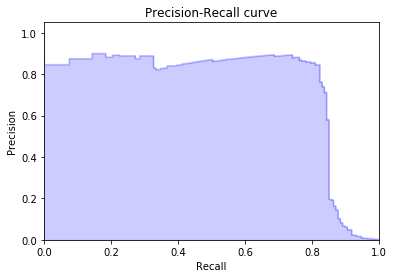

In [67]:
bbc_results = precision_recall(y_test, bbc_y_score)

In [68]:
bbc_report = bbc_results.sort_values(by='f1_score', ascending=False)
bbc_best_threshold = bbc_report.loc[bbc_report['f1_score'].idxmax(), 
                                    'threshold']

In [69]:
bbc_report.head(10)

,precision,recall,threshold,f1_score
3149,0.846,0.823,0.808,0.834
3153,0.856,0.810,0.829,0.832
3148,0.840,0.823,0.806,0.832
3150,0.845,0.816,0.810,0.830
3152,0.850,0.810,0.824,0.829
3147,0.834,0.823,0.804,0.829
3154,0.855,0.803,0.831,0.828
3156,0.860,0.796,0.853,0.827
3151,0.844,0.810,0.820,0.826
3146,0.829,0.823,0.803,0.826


In [70]:
bbc_y_pred = bbc_y_score >= bbc_best_threshold

In [71]:
print(classification_report(y_test, bbc_y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.85      0.82      0.83       147

avg / total       1.00      1.00      1.00     85443



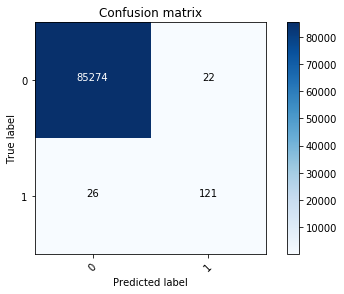

In [72]:
plot_confusion_matrix(y_test, bbc_y_pred, 
                      class_names=[0, 1])

### 4) Random Forest levando em conta as classes desbalanceadas

A classe [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) do scikit-learn, assim como a classe [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), contém o parâmetro `class_weight`, que quando setado com `balanced` faz o algoritmo ajustar os pesos de cada classe de forma inversamente proporcional à frequência das classes no dataset de treino.

Obs.: com o [`XGBoostClassifier`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier), é possível fazer algo similar utilizando-se o parâmetro `scale_pos_weight`. 
"A typical value to consider: `sum(negative cases) / sum(positive cases)`" ([fonte](https://xgboost.readthedocs.io/en/latest/parameter.html)).

In [73]:
rf_balanced = RandomForestClassifier(n_estimators=100,
                                     max_features=3,
                                     class_weight='balanced')

In [74]:
_ = rf_balanced.fit(X_train, y_train)

In [75]:
rf_balanced_y_score = rf_balanced.predict_proba(X_test)[:, 1]

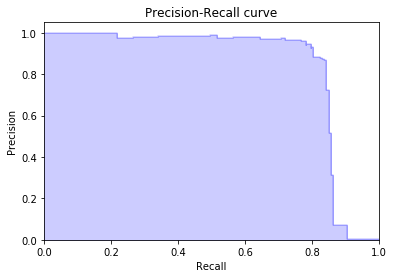

In [76]:
rf_balanced_results = precision_recall(y_test, rf_balanced_y_score)

In [77]:
rf_balanced_report = rf_balanced_results.sort_values(by='f1_score', ascending=False)
rf_balanced_best_threshold = rf_balanced_report.loc[rf_balanced_report['f1_score'].idxmax(), 
                                                    'threshold']

In [78]:
rf_balanced_report.head(10)

,precision,recall,threshold,f1_score
24,0.944,0.796,0.280,0.863
28,0.958,0.782,0.420,0.861
21,0.929,0.803,0.230,0.861
23,0.936,0.796,0.260,0.860
25,0.943,0.789,0.330,0.859
27,0.950,0.782,0.400,0.858
22,0.929,0.796,0.250,0.857
29,0.958,0.776,0.460,0.857
30,0.966,0.769,0.470,0.856
11,0.867,0.844,0.110,0.855


In [79]:
rf_balanced_y_pred = rf_balanced_y_score >= rf_balanced_best_threshold

In [80]:
print(classification_report(y_test, rf_balanced_y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.94      0.80      0.86       147

avg / total       1.00      1.00      1.00     85443



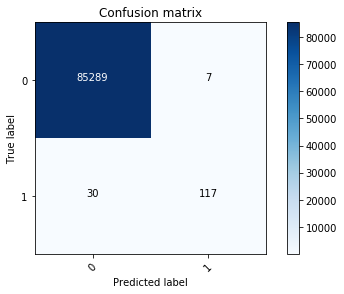

In [81]:
plot_confusion_matrix(y_test, rf_balanced_y_pred, 
                      class_names=[0, 1])